In [24]:
###-----------------
### Import libraries
###-----------------
from pathlib import Path  # Import Path for file system path operations and management
import numpy as np  # Import NumPy for numerical computations and array operations
import pandas as pd  # Import Pandas for data manipulation and analysis with DataFrames
import matplotlib.pyplot as plt  # Import Matplotlib for creating static, interactive visualizations
import seaborn as sns  # Import Seaborn for statistical data visualization built on Matplotlib

from sklearn.model_selection import train_test_split  # Import function to split dataset into training and testing subsets
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score  # Import function to calculate various metric

from collections.abc import Callable  # Type hinting callable objects/functions
from typing import Literal  # Literal type hints to restrict variable values

from sklearn.preprocessing import StandardScaler  # Import for standardizing features (zero mean, unit variance)
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix # Custom utility

\begin{align*}
& X \rightarrow X \cdot W_1 + b_1 \rightarrow \text{activation fnc }(g) \text{ (i.e. } a_1) \rightarrow a_1 \cdot W_2 + b_2 \rightarrow \text{(output } a_2) \rightarrow \text{Loss calculate} \\
& \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad|\\
& \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad dz_2 = (a_2 - y) \leftarrow \\
& \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad dw_2 = (a_1 \cdot dz_2) \\
& \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad db = dz_2 \\
& \\
& a_1 = g(z_1) \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad da_1 = W \cdot dz_2 \\
& \frac{\partial}{\partial a_1} = da_1 \\
& dz_1 = \frac{\partial L}{\partial a_1} \frac{\partial a_1}{\partial z_1} \\
& \\
& dw_1 = X \cdot dz_1 \\
& db_1 = dz_1
\end{align*}

In [38]:
###----------------------
### Some basic parameters
###----------------------

inpDir = Path('..') / '..' / 'input'
outDir = Path('..') / 'output'
modelDir = Path('..') / 'models'
subDir = 'fifa_2019'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

EPOCHS = 101 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2
TRAIN_SIZE = 454 * BATCH_SIZE
# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [40]:
device = torch.device('cude' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [27]:
data_df = pd.read_csv('fifa_2019.csv')
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 89 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                18207 non-null  int64  
 1   ID                        18207 non-null  int64  
 2   Name                      18207 non-null  object 
 3   Age                       18207 non-null  int64  
 4   Photo                     18207 non-null  object 
 5   Nationality               18207 non-null  object 
 6   Flag                      18207 non-null  object 
 7   Overall                   18207 non-null  int64  
 8   Potential                 18207 non-null  int64  
 9   Club                      17966 non-null  object 
 10  Club Logo                 18207 non-null  object 
 11  Value                     18207 non-null  object 
 12  Wage                      18207 non-null  object 
 13  Special                   18207 non-null  int64  
 14  Prefer

In [28]:
# Following columns appear to be relevant for our analysis
rel_cols = ["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [29]:
data_df = data_df[rel_cols]
data_df = data_df[data_df['Position'].notnull()]
data_df.info(), data_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 18147 entries, 0 to 18206
Data columns (total 34 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Position         18147 non-null  object 
 1   Finishing        18147 non-null  float64
 2   HeadingAccuracy  18147 non-null  float64
 3   ShortPassing     18147 non-null  float64
 4   Volleys          18147 non-null  float64
 5   Dribbling        18147 non-null  float64
 6   Curve            18147 non-null  float64
 7   FKAccuracy       18147 non-null  float64
 8   LongPassing      18147 non-null  float64
 9   BallControl      18147 non-null  float64
 10  Acceleration     18147 non-null  float64
 11  SprintSpeed      18147 non-null  float64
 12  Agility          18147 non-null  float64
 13  Reactions        18147 non-null  float64
 14  Balance          18147 non-null  float64
 15  ShotPower        18147 non-null  float64
 16  Jumping          18147 non-null  float64
 17  Stamina          

(None,
 Position           0
 Finishing          0
 HeadingAccuracy    0
 ShortPassing       0
 Volleys            0
 Dribbling          0
 Curve              0
 FKAccuracy         0
 LongPassing        0
 BallControl        0
 Acceleration       0
 SprintSpeed        0
 Agility            0
 Reactions          0
 Balance            0
 ShotPower          0
 Jumping            0
 Stamina            0
 Strength           0
 LongShots          0
 Aggression         0
 Interceptions      0
 Positioning        0
 Vision             0
 Penalties          0
 Composure          0
 Marking            0
 StandingTackle     0
 SlidingTackle      0
 GKDiving           0
 GKHandling         0
 GKKicking          0
 GKPositioning      0
 GKReflexes         0
 dtype: int64)

In [30]:
data_df.loc[data_df['Position'] == "GK", 'Position'] = 0
data_df.loc[data_df['Position'].isin(defender), 'Position'] = 1
data_df.loc[data_df['Position'].isin(midfielder), 'Position'] = 2
data_df.loc[data_df['Position'].isin(forward), 'Position'] = 3

data_df['Position'] = pd.to_numeric(data_df['Position'], downcast='integer') # to int8 else it was int64

data_df.dtypes

Position              int8
Finishing          float64
HeadingAccuracy    float64
ShortPassing       float64
Volleys            float64
Dribbling          float64
Curve              float64
FKAccuracy         float64
LongPassing        float64
BallControl        float64
Acceleration       float64
SprintSpeed        float64
Agility            float64
Reactions          float64
Balance            float64
ShotPower          float64
Jumping            float64
Stamina            float64
Strength           float64
LongShots          float64
Aggression         float64
Interceptions      float64
Positioning        float64
Vision             float64
Penalties          float64
Composure          float64
Marking            float64
StandingTackle     float64
SlidingTackle      float64
GKDiving           float64
GKHandling         float64
GKKicking          float64
GKPositioning      float64
GKReflexes         float64
dtype: object

In [7]:
class_labels = {
    0: 'Goal Keeper', 
    1: 'Defender',
    2: 'Mid-fielder',
    3: 'Forward'
}

In [8]:
labels = data_df['Position']
features_df = data_df.drop('Position', axis=1)
features_df.shape, labels.shape 


((18147, 33), (18147,))

In [39]:
train_df,test_df = train_test_split(data_df,
                                train_size=TRAIN_SIZE, 
                                random_state=RANDOM_STATE, 
                                stratify=data_df['Position'])

train_df.shape , test_df.shape

((14528, 34), (3619, 34))

In [37]:
class GlobalScaler:
    _instance = None
    def __init__(self):
        if GlobalScaler._instance is not None:
            raise Exception('GlobalScaler is Singleton Class')
    @classmethod
    def get_instance(cls):
        if cls._instance is None:
            cks._instance = GlobalScaler()
        return cls._instance

In [ ]:
class FidaDS(Dataset):
    globalScaler = GlobalScaler.get_instance() # protected variable 
    def __init__(self,dataframe,device = device ,is_train,label_col):
        self.df = dataframe
        self.device = device
        self.is_train = is_train
        self.scaler = self.globalScaler.scaler
        self.label_col = label_col

    self.labels = self.df[label_col].to_numpy()
    if self.is_train:
        X = self.df.drop(label_col , axis = 1)
        self.features = self.scaler.fit_transform(X)
    else:
        X = self.df.drop(label_col, axis = 1)
        self.features = self.scaler.transform(X)

    def __len__(self):
        retunr len(self.features)

    def __getitem__(self,index):
        features = self.features[index]
        label = self.labels[index]
        return feature,label

In [ ]:
std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

X_train.shape, X_test.shape, y_train.shape , y_test.shape

In [10]:
type(X_train), type(X_test), type(y_train), type(y_test)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

Converting to Datasets

In [11]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)) # a we are passing rows of data thats why slices. it is creating dataset for us
test_ds = tf.data.Dataset.from_tensor_slices((X_test,y_test))

In [12]:
train_ds = train_ds.shuffle(buffer_size=X_train.shape[0]).batch(BATCH_SIZE) 
test_ds = test_ds.shuffle(buffer_size=X_test.shape[0]).batch(BATCH_SIZE)


In [13]:
train_ds = train_ds.cache().prefetch(buffer_size=  tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=  tf.data.AUTOTUNE)


In [14]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 33), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int8, name=None))>

In [15]:
for fetures,labels in  train_ds.take(5):
    print(fetures.shape,labels.shape)

(64, 33) (64,)
(64, 33) (64,)
(64, 33) (64,)
(64, 33) (64,)
(64, 33) (64,)


<h1>Define Model</h1>

In [16]:
model = tf.keras.Sequential([
    tf.keras.Input(shape = (33,)),
    tf.keras.layers.Dense(27,activation='relu'),
    tf.keras.layers.Dense(21,activation='relu'),
    tf.keras.layers.Dense(15,activation='relu'),
    tf.keras.layers.Dense(9,activation='relu'),
    tf.keras.layers.Dense(4)
])

In [17]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate = ALPHA)
model.compile(optimizer = optimizer,
             loss = loss_fn,
             metrics = ['accuracy'])

In [18]:
history = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=EPOCHS)

Epoch 1/101
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7612 - loss: 0.6042 - val_accuracy: 0.8499 - val_loss: 0.3459
Epoch 2/101
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8634 - loss: 0.3258 - val_accuracy: 0.8620 - val_loss: 0.3196
Epoch 3/101
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8710 - loss: 0.3103 - val_accuracy: 0.8664 - val_loss: 0.3116
Epoch 4/101
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8748 - loss: 0.3028 - val_accuracy: 0.8691 - val_loss: 0.3078
Epoch 5/101
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8776 - loss: 0.2976 - val_accuracy: 0.8691 - val_loss: 0.3053
Epoch 6/101
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8784 - loss: 0.2936 - val_accuracy: 0.8705 - val_loss: 0.3035
Epoch 7/101
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8796 - loss: 0.2905 - val_accuracy: 0.8725 - val_loss: 0.3026
Epoch 8/101
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8803 - loss: 0.2883 - val_accu

In [22]:
model.evaluate(train_ds,verbose=2)


227/227 - 0s - 1ms/step - accuracy: 0.9028 - loss: 0.2332


[0.23322588205337524, 0.9028035998344421]

<h1>Prediction</h1>

In [20]:
y_true,y_pred = [],[]
for feat,lbls in train_ds:
    pred = model(feat).numpy()
    y_true.extend(lbls)
    y_pred.extend(pred.argmax(axis = 1))
print(f'Accuracy : {accuracy_score(y_true,y_pred)}')
print(f'Accuracy : {classification_report(y_true,y_pred)}')

Accuracy : 0.9028036095612041
Accuracy :               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1620
           1       0.90      0.98      0.94      4693
           2       0.88      0.87      0.87      5470
           3       0.89      0.79      0.84      2734

    accuracy                           0.90     14517
   macro avg       0.92      0.91      0.91     14517
weighted avg       0.90      0.90      0.90     14517



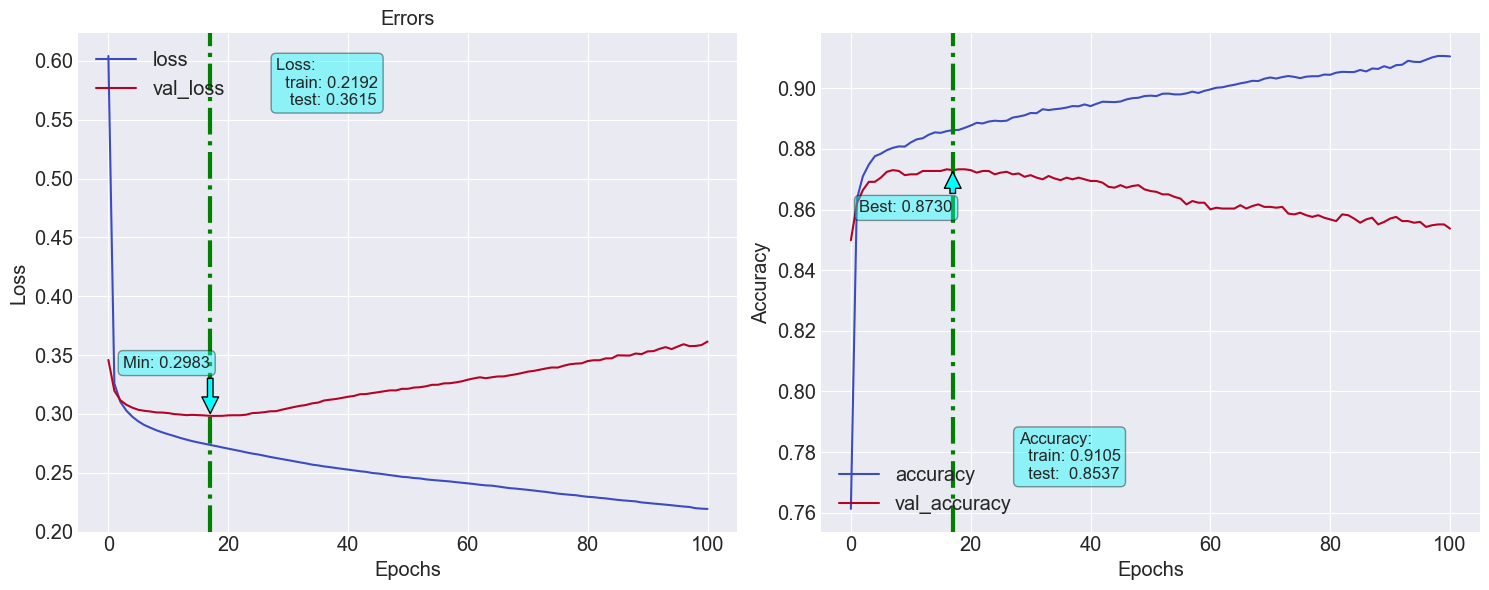

In [21]:
loss_df = pd.DataFrame(history.history)
fn_plot_tf_hist(loss_df)